### 0. Prerequisites

This notebook uses the following additional packages. Please install them if you need to add the libraries to your environment.

ex) !pip install pymupdf

- pymupdf
- pandas
- matplotlib
- networkx

Please see the following items if you want just to know the final results without running the notebook.

- **Relationship-Weight:** ./relationship.csv
- **Centrality:** ./centrality.csv
- **Network Diagram:** ./image/networkx.png

### 1. Collect & Convert AWS guides

This phase is a preparation phase before starting analytics.
By default, "pdf" folder of this repository is empty. Please download AWS official PDF guides from here (https://docs.aws.amazon.com/index.html), and put them into "pdf" folder on your own.
In my case, I selected 30 services that I listed in README.md. You do not need to put the same 30 services; arbitrary AWS official PDF files are OK, as you like. Make sure that you must **rename those PDF file names to service names** (Not download bare file names).

Please run the following cell after putting the PDF files in the "pdf" folder.
This code converts all PDF files in "pdf" folder to text files and saves the text files in "text" folder. Please confirm your "text" folder after running the cell.

Here is my example.  
**Left Fig.:** pdf folder after putting PDF files  
**Right Fig.:** text folder after running the following cell  
(* If no figure is displayed, then see ./image/pdf-text-folder.png picture)  
<img src="./image/pdf-text-folder.png" width="250">

In [2]:
import glob
import os
import fitz

# Collect PDF files
pdf_paths = glob.glob("./pdf/*.pdf")

for pdf_path in pdf_paths:

    pdf_object = fitz.open(pdf_path)
    output_text_path = "./text/" + os.path.basename(pdf_path) + ".txt"

    # Convert PDF files to text files
    with open(output_text_path, "w") as text_file:
        for page in pdf_object:
            text_file.write(page.get_text("text"))
        pdf_object.close()
    text_file.close()

mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict
mupdf: invalid key in dict


### 2. Count & Aggregation

This phase is an analytics phase that counts and aggregates the appearances of service names in guides.
This notebook proceeds according to the following steps.
The calculation results will show as pandas data frames.

1. Calculation of the Relationship-Weight
1. Calculation of the Centrality
1. Export the Result

In [3]:
import pandas as pd
import re

# Set up file information 
file_info = {}
text_paths = glob.glob("./text/*.txt")

for text_path in text_paths:
    service_name = os.path.basename(text_path).replace(".pdf.txt", "")
    file_info[service_name] = {
        "path": text_path,
        "text_size_mb": os.path.getsize(text_path) / (1024.0 ** 2),
    }

relationship_df = pd.DataFrame(index=[], columns=["source", "target", "word_count", "text_size_mb", "weight"])

# Start measurement
for source_service in file_info.keys():

    text_df = pd.read_csv(file_info[source_service]["path"], sep="\r\n", header=None, names=["text_line"], engine="python",)
    text_size_mb = file_info[source_service]["text_size_mb"]

    for target_service in file_info.keys():

        if source_service == target_service:  # Skip self-reference relationship
            continue

        # This reg-pattern aims to find service names in natural sentences of guide, avoiding over-counting
        # such like places where ARN, SDK Code, URL, Permission Template. But, a few over-counting are unavoidable...
        pattern = re.compile("(?i)(^|[- \[{(])" + target_service + "($|[- ,.!?\]})])")

        # Count appearances of service names in a line
        word_count_df = text_df["text_line"].apply(
            lambda text_line: len(pattern.findall(str(text_line)))
        )

        # Aggregate appearances of service names in a guide
        relationship_df = relationship_df.append(
            {
                "source": source_service,
                "target": target_service,
                "word_count": word_count_df.sum(),
                "text_size_mb": round(text_size_mb, 3),
                "weight": round(word_count_df.sum() / text_size_mb, 3),
            },
            ignore_index=True,
        )

relationship_df = relationship_df.sort_values(["source", "target"]).reset_index(drop=True)
relationship_df

,source,target,word_count,text_size_mb,weight
0,API Gateway,Amplify,4,1.678,2.384
1,API Gateway,Athena,0,1.678,0.000
2,API Gateway,Aurora,0,1.678,0.000
3,API Gateway,Cloud9,0,1.678,0.000
4,API Gateway,CloudFront,49,1.678,29.205
...,...,...,...,...,...
865,X-Ray,S3,58,0.677,85.711
866,X-Ray,SNS,83,0.677,122.656
867,X-Ray,SQS,46,0.677,67.978
868,X-Ray,SageMaker,0,0.677,0.000


In [4]:
# Calculate the centrality from relationship weight values.
centrality_df = (
    relationship_df.groupby("target", as_index=False)["weight"]
    .agg("sum")
    .set_axis(["service", "centrality"], axis=1)
    .sort_values("centrality", ascending=False)
    .reset_index(drop=True)
)
centrality_df

,service,centrality
0,IAM,9804.513
1,EC2,5992.281
2,S3,5805.187
3,VPC,5332.025
4,Lambda,3399.722
5,CloudWatch,3108.823
6,RDS,1187.426
7,KMS,1151.629
8,Glue,890.108
9,SNS,758.741


In [5]:
# Export the data frame of weight and centrality to CSV files 
relationship_df.to_csv('relationship.csv', index=False)
centrality_df.to_csv('centrality.csv', index=False)

### 3. Visualization

This visualization phase shows which two services have strong relationship or which services are strongly referred from many other services.
The following code assumes to use my selected 30 services; therefore, please arrange "pos" variable to fit your selected services.

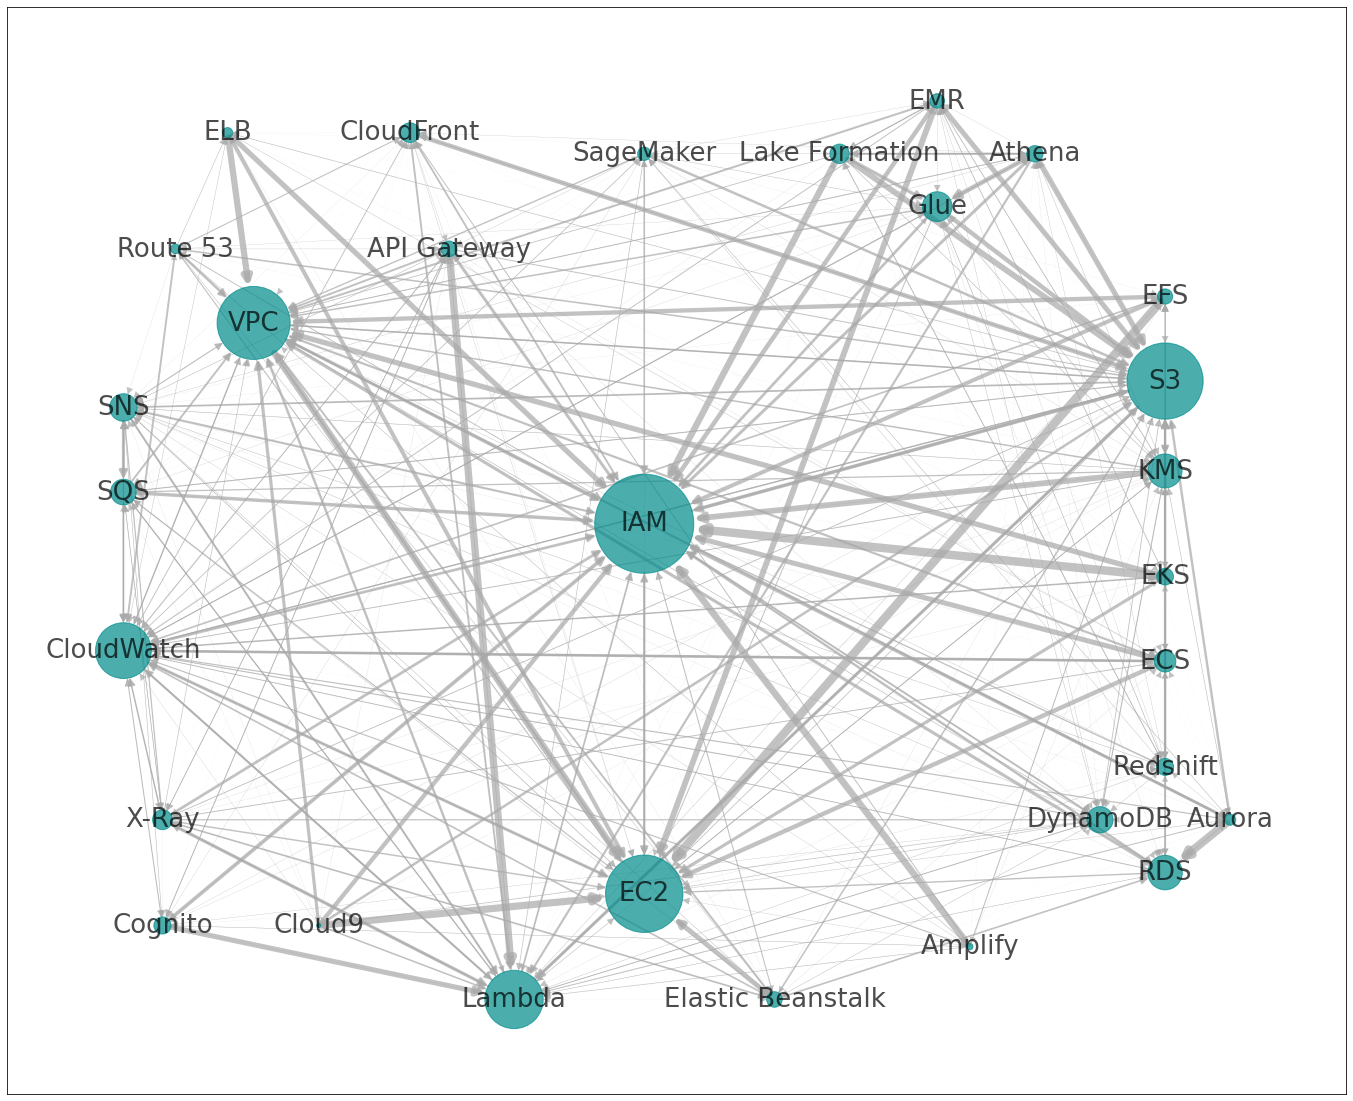

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Node Setup
node_list = centrality_df["service"].values
centrality_list = centrality_df["centrality"].values
# Please arrange "pos" variable for your selected services
pos = {
    "IAM": (0, 50),
    "EC2": (0, -300),
    "Elastic Beanstalk": (100, -400),
    "Lambda": (-100, -400),
    "Amplify": (250, -350),
    "RDS": (400, -280),
    "Aurora": (450, -230),
    "Redshift": (400, -180),
    "DynamoDB": (350, -230),
    "ECS": (400, -80),
    "EKS": (400, 0),
    "KMS": (400, 100),
    "S3": (400, 185),
    "EFS": (400, 265),
    "Athena": (300, 400),
    "Glue": (225, 350),
    "Lake Formation": (150, 400),
    "EMR": (225, 450),
    "SageMaker": (0, 400),
    "API Gateway": (-150, 310),
    "CloudFront": (-180, 420),
    "ELB": (-320, 420),
    "Route 53": (-360, 310),
    "VPC": (-300, 240),
    "SNS": (-400, 160),
    "SQS": (-400, 80),
    "CloudWatch": (-400, -70),
    "X-Ray": (-370, -230),
    "Cloud9": (-250, -330),
    "Cognito": (-370, -330),
}

# Edge Setup
edge_list = []
linewidth_list = []
for index, row in relationship_df.iterrows():
    if row["word_count"] > 0:
        edge_list.append((row["source"], row["target"]))
        linewidth_list.append(row["weight"] / 100)

# Visalization
plt.figure(figsize=(24, 20))
G = nx.MultiDiGraph()
G.add_nodes_from(node_list)
nx.draw_networkx(
    G,
    pos,
    with_labels=True,
    edgelist=edge_list,
    node_size=centrality_list,
    width=linewidth_list,
    node_color="darkcyan",
    edge_color="darkgray",
    alpha=0.7,
    font_size=26,
    arrowsize=16,
)
plt.show()